# Mission

Our dataset contains daily observations of station-based measurements worldwide.

We have chosen to look into stations in Italy, which has the oldest records, and Canada, which also has entries dating back to 1840, to identify contrasts. By looking into the precipitation data, we aim to gain insights in climate change, and understand the fluctuations.

The data can is located in an AWS bucket. An overview of the bucket can be found here: http://noaa-ghcn-pds.s3.amazonaws.com/.

It is an archive containing data from 1763 to 2022 of "GHCN-Daily", which is a dataset produced by NOAA’s National Centers for Environmental Information (NCEI) that is updated daily and contains daily weather observations for numerous countries worldwide. The files are in a .csv format.

To check the README of the dataset, you can check out https://docs.opendata.aws/noaa-ghcn-pds/readme.html

__________

# Imports

In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00


In [2]:
import os
import glob
import pandas as pd
import gc

# AWS Bucket interaction
import boto3
from botocore import UNSIGNED
from botocore.config import Config

# Visualization
import matplotlib.pyplot as plt

___________

# Data Download

This part of the notebook connects to the bucket, checks if the desired files are present in the local path, and downloads them if they are not.

### Setup Bucket connection

In [3]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_resource = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3_resource.Bucket('noaa-ghcn-pds')

# General Data EDA

While we possess extensive meteorological data spanning the globe and multiple centuries, a limitation of our dataset is the inconsistent recording practices employed by various weather stations. This factor can introduce ambiguity when attempting to discern long-term patterns in climate change. To overcome this obstacle and obtain a clearer picture of shifting weather trends, we chose to narrow our focus onto two distinct, preferably far apart from each other, countries, thereby minimizing the impact of extraneous factors such as ocean currents or topographical anomalies that might skew our analysis.

To determine which two countries would be most suitable for comparison, we initiated an exploratory data analysis (EDA) of the entire dataset.

#### Getting all datafiles per year

In [4]:
# Change local path depending on where data will be downloaded to
data_root = 'LOCAL_PATH'

In [5]:
column_names = ['ID', 'DATE', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']

In [6]:
years = []
for obj in bucket.objects.all():
    if 'by_station' not in obj.key:
        _, filename = os.path.split(obj.key)
        local_path = data_root + filename
        if not os.path.isfile(local_path):
            #print(filename, ' downloaded')
            years.append(filename.split('.')[0])
            s3_client.download_file('noaa-ghcn-pds', obj.key, local_path)
    else:
        break

print("All {} filenames downloaded.".format(len(years)))

All 260 filenames downloaded.


In [7]:
list(map(int, years))
print('First year recorded: ', min(years))
print('Last year recorded: ', max(years))

First year recorded:  1763
Last year recorded:  2022


In [8]:
def load_df(year):
  """
  Load the data from the specified year into a pandas DataFrame.
  Extract the country and station identifiers from the 'ID' column for easier analysis.
  Transform the 'DATE' column to datetime format for easier analysis.

  year : the respective year-long data recordings to be transformed into a dataframe
  """
  df = pd.read_csv(data_root + str(year) + '.csv.gz', header = 0, names = column_names)

  df['COUNTRY'] = df['ID'].str[:2]
  df['STATION'] = df['ID'].str[2:]
  df['YEAR'] = df['DATE'] // 10000

  return df

def load_df_by_station(station):
  """
  Load only data corresponding to a specific station into a pandas DataFrame.
  station: the desired station
  """
  df = pd.read_csv(data_root + station + '.csv.gz', header = 0, names = column_names)
  df['STATION'] = df['ID'].str[2:]
  df['YEAR'] = df['DATE'] // 10000

  return df

def load_df_part(year, column_index, column):
  """
  Load only part from the specified year into a pandas DataFrame.
  year : the respective year-long data recordings to be transformed into a dataframe
  column: the desired columns
  """
  df = pd.read_csv(data_root + str(year) + '.csv.gz', header = 0, usecols=[column_index], names = column)

  return df

#### Let's see a test dataframe

In [9]:
gc.collect()

16360

In [10]:
df_1989 = load_df(1989)
df_1989.head()

,ID,DATE,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,COUNTRY,STATION,YEAR
0,AE000041196,19890101,TAVG,187,H,NaN,S,NaN,AE,000041196,1989
1,AEM00041194,19890101,TMAX,235,NaN,NaN,S,NaN,AE,M00041194,1989
2,AEM00041194,19890101,TAVG,212,H,NaN,S,NaN,AE,M00041194,1989
3,AEM00041217,19890101,TMAX,233,NaN,NaN,S,NaN,AE,M00041217,1989
4,AEM00041217,19890101,TMIN,147,NaN,NaN,S,NaN,AE,M00041217,1989


In [11]:
def dataframe_summary(df):
  """
  Returns a few descriptive statistics about a dataframe, such as amount of empty values and number of unique values for the weather column,
  most and least recorded countries and stations.

  df: the dataframe to be summarized
  """
  summary = {}

  # Column types
  summary['column_types'] = df.dtypes

  # Count of NaNs per column
  summary['nan_count'] = df.isnull().sum()

  # Top 10 recorded couwntries and stations
  cols = ['COUNTRY', 'STATION']
  top_records = {}
  for col in cols:
      top_records[col] = df[col].value_counts().head(10)

  # Create subplots for top recorded countries and stations
  fig, axes = plt.subplots(2, figsize=(6, 6))
  for i, (col, records) in enumerate(top_records.items()):
      ax = axes[i]
      ax.bar(records.index, records.values, color='skyblue')
      ax.set_title(f'Top 10 Recorded {col}')
      ax.set_xlabel(col)
      ax.set_ylabel('Count')
      ax.tick_params(axis='x', rotation=45)

  plt.tight_layout()
  plt.show()

  # Plot counts for 'ELEMENT' (weather)
  element_counts = df['ELEMENT'].value_counts()
  mean_count = element_counts.mean()  # Take only values that occur more than half the time to be memory efficient
  filtered_element_counts = element_counts[element_counts > mean_count]

  plt.figure(figsize=(6, 3))
  filtered_element_counts.plot(kind='bar', color='skyblue')
  plt.title('Counts for ELEMENT (filtered)')
  plt.xlabel('ELEMENT')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.show()

  return summary

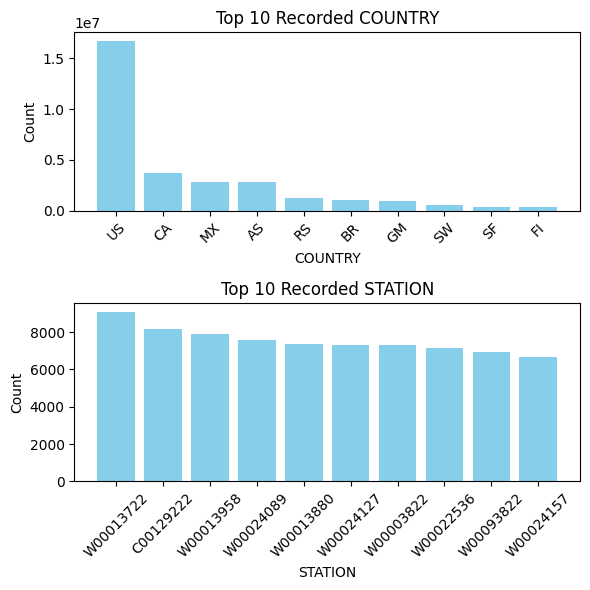

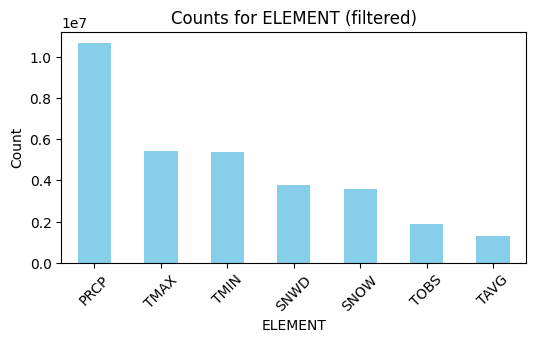

{'column_types': ID             object
 DATE            int64
 ELEMENT        object
 DATA VALUE      int64
 M-FLAG         object
 Q-FLAG         object
 S-FLAG         object
 OBS-TIME      float64
 COUNTRY        object
 STATION        object
 YEAR            int64
 dtype: object,
 'nan_count': ID                   0
 DATE                 0
 ELEMENT              0
 DATA VALUE           0
 M-FLAG        27134573
 Q-FLAG        33935372
 S-FLAG               0
 OBS-TIME      25713434
 COUNTRY              0
 STATION              0
 YEAR                 0
 dtype: int64}

In [12]:
summary = dataframe_summary(df_1989)
summary

So, with a quick look, we can see that in 1989, the USA had the most weather recordings. The corresponding most active weather station is also in the USA. You can use https://www.ncdc.noaa.gov/cdo-web/datatools/findstation to pinpoint the location of a station based on its **WBAN identification number**. We can see our most recorded station is in Nebraska.

![Nebraska Station Location]('/content/nebraska.PNG')

We can also notice that there many empty entries for measurement flag (*M-FLAG*), quality flag (*Q_FLAG*), and observation time (*OBS-TIME*). This means we can expect that our analysis will only contain the weather conditions on a specific day, disregarding how it was measured. Also, most recordings focus on temperature (*max, min, avg temperature*).

As a reminder, you can check the meaning of all symbols at http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt.

Okay, now that we're done looking at it, let's delete the data frame to free up some memory.

In [13]:
del df_1989
gc.collect()

11143

## Selecting countries

In order to create a comprehensive and reliable database of weather observations, we aim to prioritize countries with the longest continuous records of data collection, providing a more robust foundation for analyzing trends and making informed decisions about climate change. Aditiionally, it is important to select countries that are still actively collecting data today, ensuring that the database remains up-to-date and relevant.

To achieve this, we conduct a search to identify the earliest recording stations around the world, taking into account factors such as the availability of historical records and completeness. Next, we rank these stations based on the total number of recordings they have collected over the first 100 years of recorded observations, giving preference to those with the largest number of observations. This ranking allows us to prioritize countries with the most extensive datasets, which in turn enables us to build a more accurate and reliable picture of long-term climate trends.

In [14]:
def oldest_countries():
  """
  Retrieves the top 10 countries with the most entries in the earliest 100 years recorded in the dataset, along with their first appearance year.
  """
  years_range = range(int(min(years)), int(min(years)) + 100)
  oldest = pd.DataFrame()
  country_first_year = {}

  for year in years_range:
      old = load_df(year)
      oldest = pd.concat([oldest, old], axis=0)
      for country in old['COUNTRY'].unique():
          if country not in country_first_year or year < country_first_year[country]:
              country_first_year[country] = year

  grouped = oldest.groupby(['COUNTRY', 'STATION']).size().reset_index(name='ENTRY_COUNT')
  grouped_data_sorted = grouped.sort_values(by='ENTRY_COUNT', ascending=False)

  del oldest, grouped
  gc.collect()

  top_10 = grouped_data_sorted.head(10)

  # Plotting the results
  plt.figure(figsize=(6, 6))
  plt.barh(range(len(top_10)), top_10['ENTRY_COUNT'], color='skyblue')
  plt.yticks(range(len(top_10)), [f"{country} - {station}" for country, station in zip(top_10['COUNTRY'], top_10['STATION'])])
  plt.xlabel('Entry Count')
  plt.ylabel('Country - Station')
  plt.title('Top 10 Entry Count by Country and Station')
  plt.gca().invert_yaxis()
  plt.show()

  # Displaying the top 10 countries with their first appearance year
  top_10_with_years = top_10.copy()
  top_10_with_years['FIRST_YEAR'] = [country_first_year[country] for country in top_10_with_years['COUNTRY']]
  top_10_with_years = top_10_with_years.sort_values(by='FIRST_YEAR')

  del top_10
  return top_10_with_years[['COUNTRY', 'FIRST_YEAR', 'STATION']]

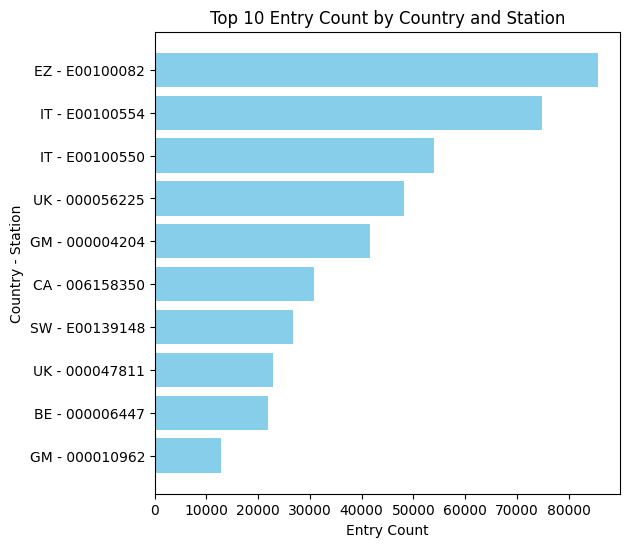

,COUNTRY,FIRST_YEAR,STATION
49,IT,1763,E00100554
46,IT,1763,E00100550
40,EZ,1775,E00100082
41,GM,1781,000004204
42,GM,1781,000010962
72,UK,1814,000056225
71,UK,1814,000047811
37,BE,1833,000006447
67,SW,1836,E00139148
38,CA,1840,006158350


In [15]:
oldest_countries()

We see that Italy is the country that has been recording for the longest, with 2 stations, meaning it is a reliable data source. Most of the oldest stations are all located in Europe, except CA- Canada. We choose that as our second country to analyse due to its geographical position. However, since these recordings are very old, we need to check if the corresponding stations still exist.

In [16]:
def station_still_exists(stations):
  """
  Quick check if the oldest stations we are interested in are still present today.
  stations: the stations to be checked
  """

  # Load the latest year
  df = load_df_part(int(max(years)), 0, ['ID'])
  df['STATION'] = df['ID'].str[2:]


  for station in stations:
    if station in df['STATION'].unique():
        print(f"{station} is present in {int(max(years))}.")
    else:
        print(f"{station} is not present in {int(max(years))}.")

  del df
  gc.collect()

In [17]:
station_still_exists(['E00100554', 'E00100550', '006158350']) # I cant tell if Im doing something wrong here and im having a mental breakdown, will fix later

E00100554 is not present in 2022.
E00100550 is not present in 2022.
006158350 is not present in 2022.


# Download files per station

There are two types of files in the bucket: one `.csv` per year between 1763 and 2022 (e.g. `csv.gz/2019.csv.gz`), and one `.csv` per station (e.g. `csv.gz/by_station/AGE00147713.csv.gz`). The prefix of the `by_station` ID (such as "AGE00147713") indicates the country, whereas one country can have multiple prefixes (e.g. "IT", "ITE", "ITM" and "ITW" for Italy).

The yearly files combine the data of all stations which have datapoints for that year, and the ones per station combine all the years for which data was recorded for that station. Since we are only interested in the stations in Italy, we only download the files which have `by_station` and "IT" in the URL. This will also include Italy's other prefixes.

As the files in the bucket are sorted (yearly files first, files per station after in alphabetical order), the iteration stops after the first element that has `by_station/IV` in its key, which is the next country prefix after Italy.

## ITALY

### Load file

In [18]:
gc.collect()

0

In [19]:
def load_country(country_code, start_year=None, end_year=None):
    """
    A function to create a dataframe of the data related to a country between certain years
    country_code:
    start_year:
    end_year:
    """
    df_list = []

    for obj in bucket.objects.all():
        if 'by_station' not in obj.key and obj.key.endswith('.csv.gz'):
            _, filename = os.path.split(obj.key)
            year = int(filename.split('.')[0])  # Extract the year from the filename

            if (start_year is not None and year < start_year):
                continue

            if (end_year is not None and year > end_year):
                break

            local_path = data_root + filename

            if not os.path.isfile(local_path):
                print("Downloading:", obj.key)  # Print when downloading for debugging
                s3_client.download_file('noaa-ghcn-pds', obj.key, local_path)

            df = load_df(year)
            df = df[df['COUNTRY'] == country_code]
            df_list.append(df)

            del df
            gc.collect()

    print("Number of files processed:", len(df_list))  # Print number of files processed
    combined_df = pd.concat(df_list, ignore_index=True, axis=0)

    return combined_df

In [20]:
italy_df = load_country('IT', 1763, 1850) # am crash with more
italy_df.head()

Number of files processed: 88


,ID,DATE,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,COUNTRY,STATION,YEAR
0,ITE00100554,17630101,TMIN,-50,NaN,NaN,E,NaN,IT,E00100554,1763
1,ITE00100554,17630102,TMAX,-26,NaN,NaN,E,NaN,IT,E00100554,1763
2,ITE00100554,17630102,TMIN,-40,NaN,NaN,E,NaN,IT,E00100554,1763
3,ITE00100554,17630103,TMAX,-9,NaN,NaN,E,NaN,IT,E00100554,1763
4,ITE00100554,17630103,TMIN,-29,NaN,NaN,E,NaN,IT,E00100554,1763


In [21]:
italy_df.sample(20)

,ID,DATE,ELEMENT,DATA VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,COUNTRY,STATION,YEAR
14049,ITE00100554,17820401,TMIN,81,NaN,NaN,E,NaN,IT,E00100554,1782
67295,ITE00100550,18280309,PRCP,0,NaN,NaN,E,NaN,IT,E00100550,1828
102624,ITE00100554,18421114,TMAX,145,NaN,NaN,E,NaN,IT,E00100554,1842
23338,ITE00100554,17941219,TMAX,0,NaN,NaN,E,NaN,IT,E00100554,1794
109652,ITE00100554,18450814,TMAX,253,NaN,NaN,E,NaN,IT,E00100554,1845
88191,ITE00100554,18370117,TMIN,-55,NaN,NaN,E,NaN,IT,E00100554,1837
105082,ITE00100554,18431031,TMIN,100,NaN,NaN,E,NaN,IT,E00100554,1843
113992,ITE00100554,18470426,TMAX,170,NaN,NaN,E,NaN,IT,E00100554,1847
57294,ITE00100554,18230816,TMAX,256,NaN,NaN,E,NaN,IT,E00100554,1823
10758,ITE00100554,17770929,TMAX,225,NaN,NaN,E,NaN,IT,E00100554,1777


In [22]:
italy_df['ELEMENT'].unique()

array(['TMIN', 'TMAX', 'PRCP'], dtype=object)

### Weather Analysis

In [32]:
def plot_weather_across_years(df):
  plot_average_temperature_across_years(df)
  plot_average_precipitation_across_years(df)
  plot_average_days_of_snow(df)

def plot_average_temperature_across_years(df):
    temperature_data = df[df['ELEMENT'] == 'TMAX']

    # Convert temperature data to Celsius (data is recorded in tenths of Celsius)
    temperature_data['Temperature'] = temperature_data['DATA VALUE'] #/ 10
    average_temperature = temperature_data.groupby(temperature_data['YEAR'])['Temperature'].mean()
    average_temperature

    # Plot the average temperature
    plt.figure(figsize=(8, 4))
    plt.plot(average_temperature, marker='o', linestyle='-', color='skyblue')
    plt.title('MAX Temperature Across Years')
    plt.xlabel('Year')
    plt.ylabel('MAX Temperature (°C)')
    plt.grid(True)
    plt.show()

def plot_average_precipitation_across_years(df):
    prcp_data = df[df['ELEMENT'] == 'PRCP']

    average_prcp= prcp_data.groupby(prcp_data['YEAR'])['DATA VALUE'].mean()

    # Plot the average temperature
    plt.figure(figsize=(8, 4))
    plt.plot(average_prcp, marker='o', linestyle='-', color='skyblue')
    plt.title('Average Precipitation Across Years')
    plt.xlabel('Year')
    plt.ylabel('Average Precipitaion (tenths of mm)')
    plt.grid(True)
    plt.show()


def plot_average_days_of_snow(df):
  #snow_days_per_year = df[df['ELEMENT'] == 'SNOW'].groupby(df['DATE'].dt.year).count()
  snow_data = df[df['ELEMENT'] == 'SNOW']

  try:
    average_snow = snow_data.groupby(snow_data['YEAR'])['DATA VALUE'].mean()

    # Plot the number of snow days per year
    plt.figure(figsize=(8, 4))
    average_snow.plot(kind='bar', color='skyblue')
    plt.title('Number of Snow Days per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Snow Days')
    plt.grid(True)
    plt.show()

  except:
    print('No snow')

<ipython-input-32-5dfa700ba4ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['Temperature'] = temperature_data['DATA VALUE'] #/ 10


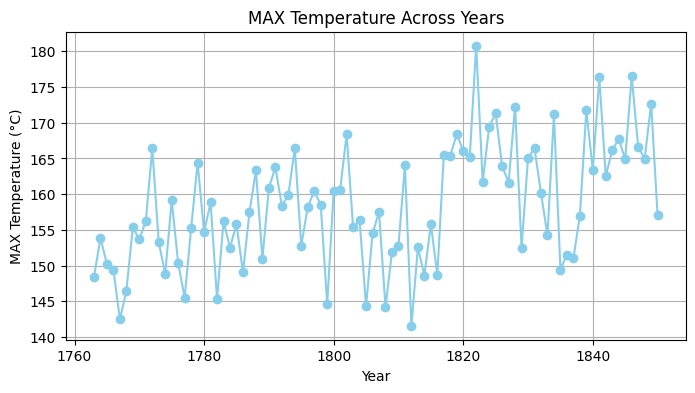

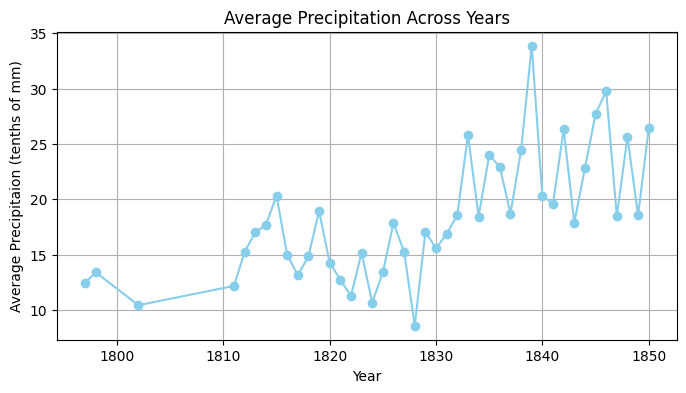

No snow


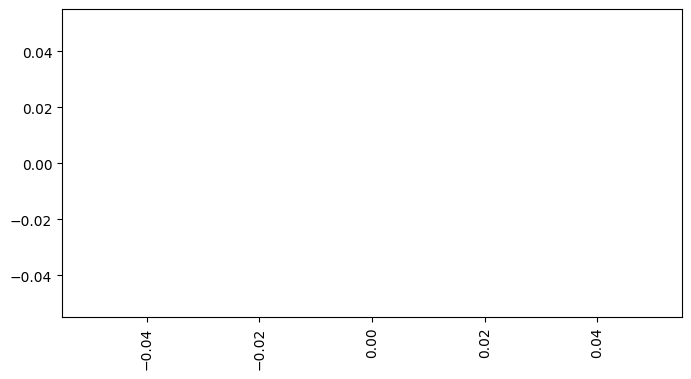

In [33]:
plot_weather_across_years(italy_df)

## CANADA

In [25]:
canada_df = load_country('CA', 1840, 1850)

Number of files processed: 11


<ipython-input-32-5dfa700ba4ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['Temperature'] = temperature_data['DATA VALUE'] #/ 10


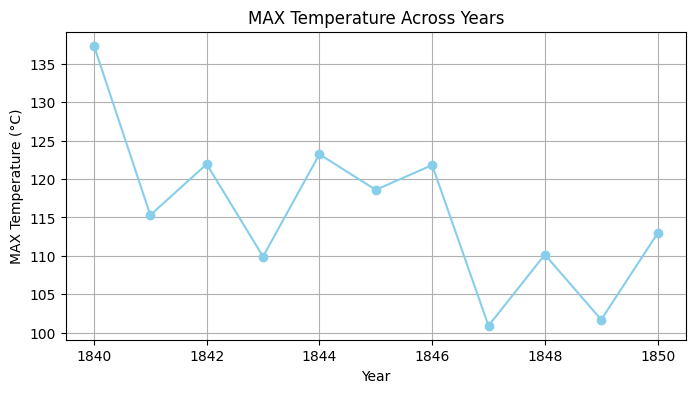

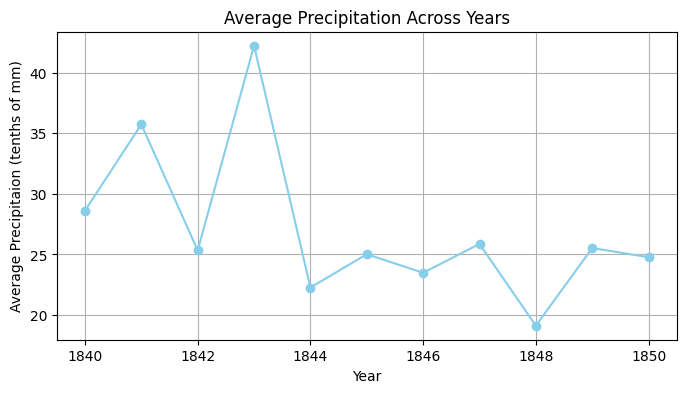

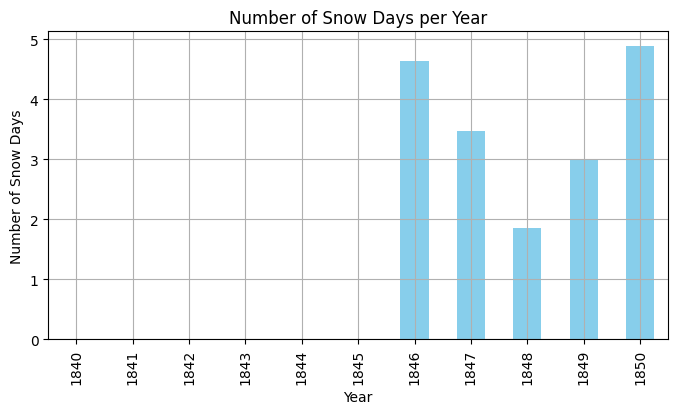

In [34]:
plot_weather_across_years(canada_df)

__________

## OLD

In [27]:
yapper

NameError: name 'yapper' is not defined

In [ ]:
# Get a list of all files in the current directory
files = glob.glob('*')

# Iterate over the list of files and delete each one
for file in files:
  try:
    os.remove(file)
  except:
    print('File could not be deleted')

In [ ]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_resource = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3_resource.Bucket('noaa-ghcn-pds')

In [ ]:
for obj in bucket.objects.all():
    # Download the files for Italian stations.
    if 'by_station/IT' in obj.key:
        _, filename = os.path.split(obj.key)
        local_path = data_root + filename
        if not os.path.isfile(local_path):
            s3_client.download_file('noaa-ghcn-pds', obj.key, local_path)
            #print(f'{filename} downloaded')
        else:
            print(f'{filename} already exists')
    # Stop the iteration after stations in Italy.
    if 'by_station/IV' in obj.key:
        break

print("All files downloaded.")